In [1]:
import numpy as np
import scipy.stats as stats
from scipy.signal import peak_widths, find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


In [2]:
class Model:
    def __init__(self, sizes, kappas):
        self.sizes = sizes
        self.kappas = kappas
        self.forward_out = [np.zeros(s) for s in sizes]
        self.backward_out = [np.zeros(s) for s in reversed(sizes)]

        self.Ws = self.vonmises_weights()


    def vonmises_weights(self):
        Ws = []
        for i in range(len(self.sizes) - 1):
            shape = (self.sizes[i+1], self.sizes[i])

            W = np.zeros(shape)
            x = np.linspace(0, 2*np.pi, shape[1])

            for ii in range(shape[0]):
                loc = ((ii/shape[0]) * 2*np.pi)
                W[ii, :] = stats.vonmises.pdf(x, self.kappas[i], loc)

            Ws.append(W)

        return Ws
    

    def attention(self, a, kappa=0):
        if kappa:
            x = np.linspace(0, 2*np.pi, a.shape[0])
            loc = (a.argmax()/a.shape[0]) * 2 * np.pi
            attn = stats.vonmises.pdf(x, kappa, loc)
        else:
            attn = np.ones(a.shape[0])
            
        return attn
    

    def forward(self, x, a_list = []):
        self.forward_out[0] = x

        for i, W in enumerate(self.Ws):
            y = W @ self.forward_out[i]

            if a_list:
                y = np.multiply(y, self.attention(y, a_list[i+1]))

            y /= np.linalg.norm(y)
            
            self.forward_out[i+1] = y 

        return y
    

    def backward(self, y, a_list = []):
        self.backward_out[0] = y

        if a_list:
            y = np.multiply(y, self.attention(y, kappa = a_list[0]))
            y /= np.linalg.norm(y)
            self.backward_out[0] = y

        for i, W in enumerate(reversed(self.Ws)):
            x_hat = W.T @ self.backward_out[i]

            if a_list and i != (len(self.Ws) - 1):
                x_hat = np.multiply(x_hat, self.attention(x_hat, kappa = a_list[i+1]))

            x_hat /= np.linalg.norm(x_hat)

            self.backward_out[i+1] = x_hat

        return x_hat


    

    def plot_activations(self, figsize = [5, 5], sharey = True, 
                         divide_by_max = False):
        n_layers = len(self.forward_out)
        fig, axs = plt.subplots(len(self.forward_out), 2, figsize = figsize, sharey = sharey)

        for i, out in enumerate(self.forward_out):
            if divide_by_max: out /= out.max()
            
            x = np.linspace(-180, 180, out.shape[0])

            ax = axs[n_layers - (i+1), 0]
            ax.plot(x, out, label = "n = %d" % len(out))
            ax.set_title('Layer %d' % i)
            ax.legend()

        for i, out in enumerate(self.backward_out):
            if divide_by_max: out /= out.max()

            x = np.linspace(-180, 180, out.shape[0])

            ax = axs[i, 1]
            ax.plot(x, out, label = "n = %d" % len(out))
            ax.set_title('Layer %d' % (n_layers - (i+1)))
            ax.legend()

        fig.tight_layout()


    def compute_widths(self):
        f_widths = []
        b_widths = []

        for f in self.forward_out:
            peaks, _ = find_peaks(f)
            width, _, _, _, = peak_widths(f, peaks)
            w = np.degrees((width/f.shape[0]) * 2 * np.pi)
            f_widths.append(w)

        for b in reversed(self.backward_out):
            peaks, _ = find_peaks(b)
            width, _, _, _, = peak_widths(b, peaks)
            w = np.degrees((width/b.shape[0]) * 2 * np.pi)
            b_widths.append(w)

        return f_widths, b_widths
            



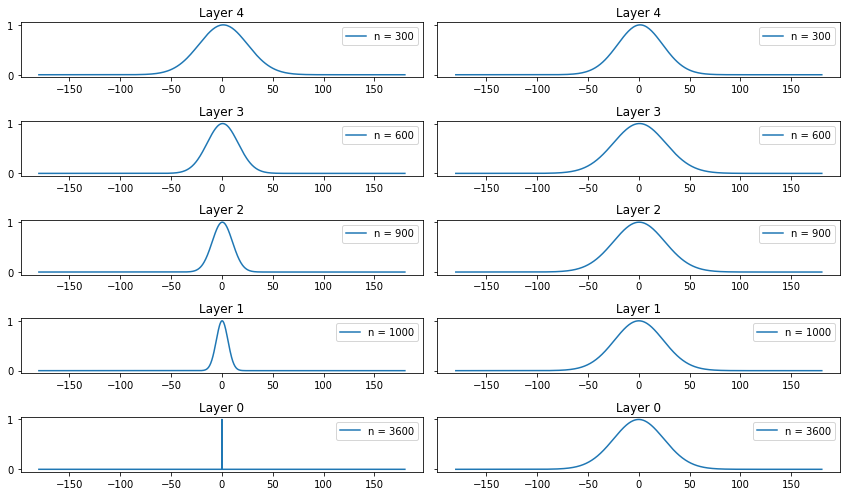

In [3]:
# Model parameters
sizes = [3600, 1000, 900, 600, 300]
kappas = [100, 50, 25, 10]
back_attn = [1, 1, 1, 1]

# Initialize model
model = Model(sizes, kappas)

# Input
x_input = np.zeros(sizes[0])
x_input[int(sizes[0]/2)] = 1

# Go up and down
y = model.forward(x_input)
x_hat = model.backward(y, a_list = back_attn)

# Plot activations in each layer
# Left column is FF, right is FB
model.plot_activations(figsize = [12, 7], sharey = True, divide_by_max=True)

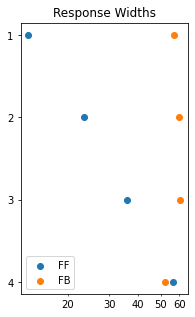

In [4]:
# Compute FWHM of responses at each layer
fw, bw = model.compute_widths()
layers = [0, 1, 2, 3, 4]
layers = [str(l) for l in layers]

# Plot widths as a function of layer hierarchy, 
# first layer at the top (consistent with plotting from paper)
plt.scatter( fw[1:],layers[1:], label = 'FF')
plt.scatter(bw[1:], layers[1:], label = 'FB')
plt.xscale('log')
plt.gcf().set_size_inches([3, 5])
plt.legend()
plt.title("Response Widths")
plt.gca().invert_yaxis()

plt.gca().xaxis.set_minor_formatter(mticker.ScalarFormatter())